In [14]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.special import erfinv
import time

### Algorytm Minimal Standard LCG

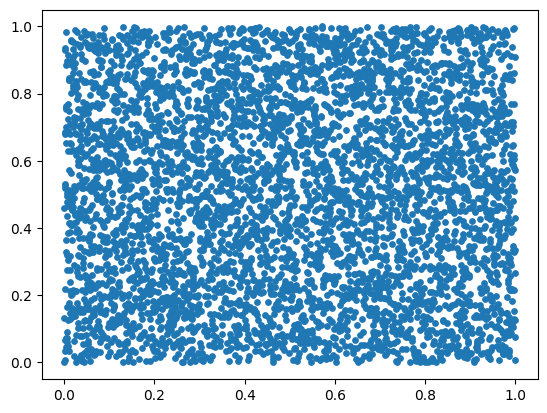

In [3]:
def linear_congruential_generator(n=10000, alfa = 7**5, beta = 0, p = 2**31 - 1):
    results = [0]*n
    random = [0]*n
    random[0] = 1
    for i in range(1, n):
        random[i] = (alfa*random[i-1] + beta)%p
    for i in range(len(random)):
        results[i] = random[i]/p
    return results

x = np.arange(0,1, 1/10000)
y = linear_congruential_generator()
plt.scatter(x[::2], y[::2], s = 15)
plt.show()

 ### Algorytm generujący liczby kwazilosowe z ciągu van der Corputa

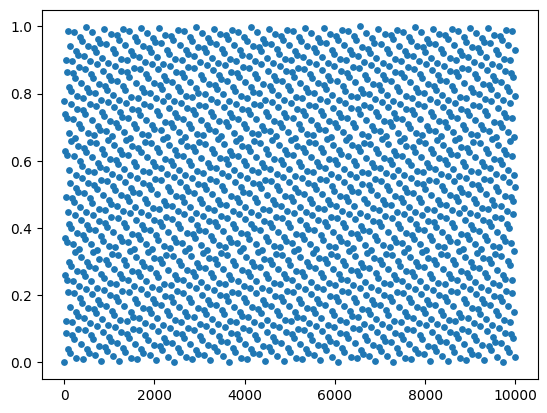

In [4]:
def van_der_corput(number, base):
    result = 0
    denominator = 1
    while number:
        denominator *= base
        number, remainder = divmod(number, base)
        result += remainder/denominator
    return result

x = [i for i in range(0, 10000, 5)]
y = [van_der_corput(i, 3) for i in x]
plt.scatter(x, y, s = 15)
plt.show()

### Algorytmy generowania rozkładów metodą odwrotnej dystrybuanty:

In [7]:
x = np.random.uniform(size = 1000)

##### - rozklad wykładniczy

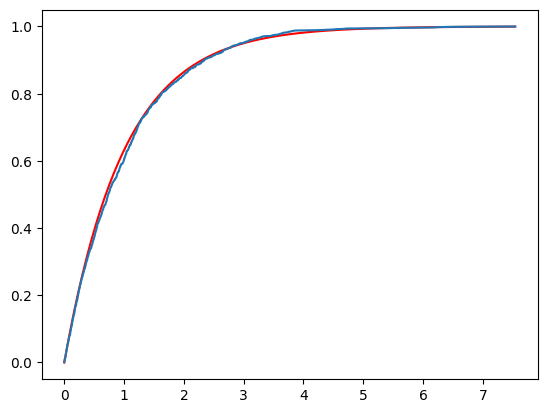

In [8]:
def invdis(lam, x):
    return (-1/lam)*np.log(x)
count, bins, ignored = plt.hist(invdis(1,x), 100, density=True)
cdf = scipy.stats.expon.cdf(bins)
ecdf = ECDF(invdis(1,x))

plt.clf()
plt.plot(bins, cdf, c='red')
plt.plot(ecdf.x, ecdf.y)
plt.show()

##### - rozkład normalny

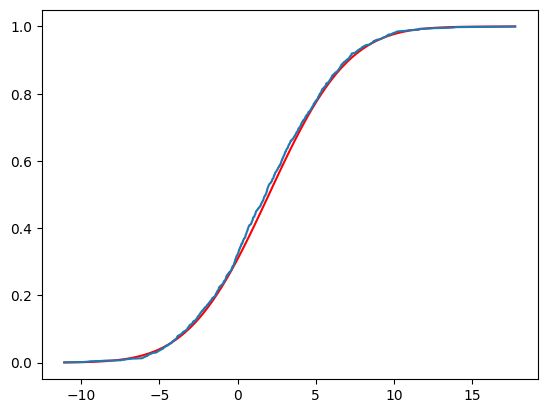

In [9]:
def invdis(mi, sigma, x):
    return mi + sigma*np.sqrt(2)*erfinv(2*x-1)
count, bins, ignored = plt.hist(invdis(2,4,x), 100, density=True)
cdf = scipy.stats.norm.cdf(bins,2,4)
ecdf = ECDF(invdis(2, 4, x))

plt.clf()
plt.plot(bins, cdf, c='red')
plt.plot(ecdf.x, ecdf.y)
plt.show()

##### - rozkład Cauchy'ego

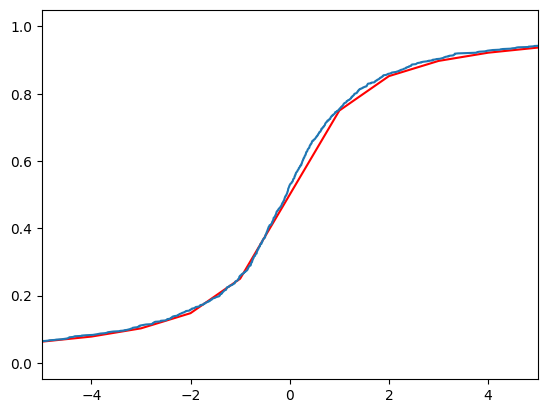

In [10]:
def invdis(mi, gamma, x):
    return mi + gamma*np.tan(np.pi*(x-0.5))
bins = [i for i in range(-5,6)]
cdf = scipy.stats.cauchy.cdf(bins)
ecdf = ECDF(invdis(0,1,x))

plt.clf()
plt.xlim(-5,5)
plt.plot(bins, cdf, c='red')
plt.plot(ecdf.x, ecdf.y)
plt.show()

##### - rozkład geometryczny

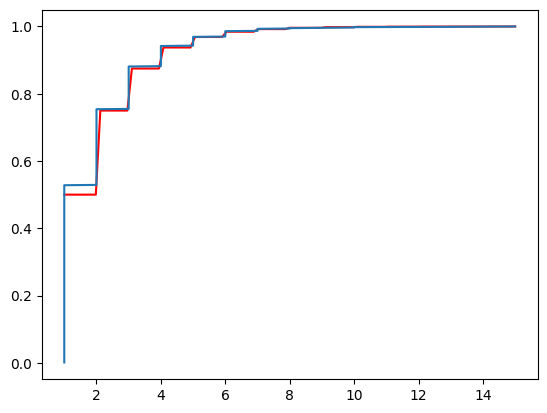

In [11]:
def invdis(p,x):
    return np.ceil((np.log(1-x))/(np.log(1-p)))
count, bins, ignored = plt.hist(invdis(0.5,x), 100, density=True)
cdf = scipy.stats.geom.cdf(bins,0.5)
ecdf = ECDF(invdis(0.5,x))


plt.clf()
plt.plot(bins, cdf, c='red')
plt.plot(ecdf.x, ecdf.y)
plt.show()

##### - rozklad Poissona

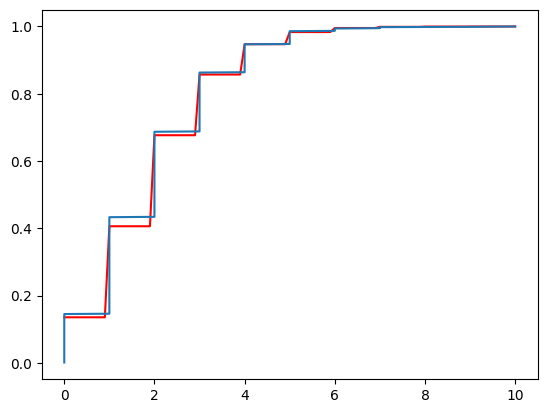

In [12]:
def invdis(lam,x):
    sum = []
    for i in x:
        j = 0
        n = 0
        p = np.e**-lam
        F = p
        while i > F:
            p = p*lam/(n+1)
            F += p
            j += 1
            n += 1
        sum.append(j)
    return sum
count, bins, ignored = plt.hist(invdis(2, x), 100, density=True)
cdf = scipy.stats.poisson.cdf(bins, 2)
ecdf = ECDF(invdis(2, x))

plt.clf()
plt.plot(bins, cdf, c='red')
plt.plot(ecdf.x, ecdf.y)
plt.show()

### Algorytm metody akceptacji-odrzucenia

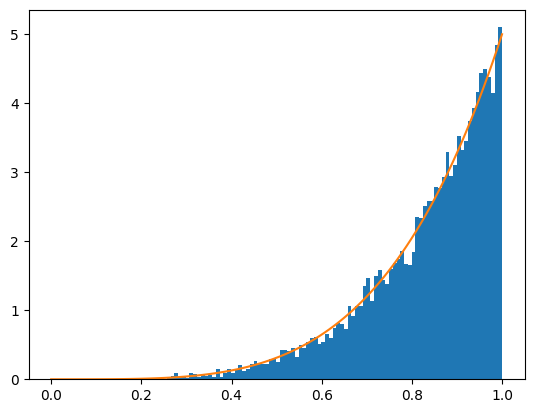

In [19]:
def accept(p, n, x, C):
    vals = []
    for i in range(n):
        u1 = np.random.uniform(0,x)
        u2 = np.random.uniform(0,C)
        while u2 > p(u1):
            u1 = np.random.uniform(0,x)
            u2 = np.random.uniform(0,C)
        vals.append(u1)
    return vals

C = 5
def p(x):
    return C*x**4
x = np.linspace(0,1,100)
plt.hist(accept(p, 10000, 1, C), bins=100, density=True)
plt.plot(x,p(x))
plt.show()

### Algorytm metody biegunowej w wersji Boxa–Mullera

Metoda Boxa-Mullera, czas wykonania: 0.0019123000092804432


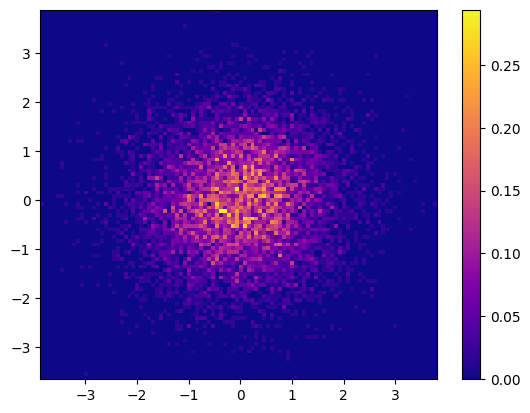

In [15]:
def box_muller(n):
    U1 = np.random.uniform(0,1, size = n)
    U2 = np.random.uniform(0,1, size = n)
    X = np.sqrt(-2*np.log(U1))*np.cos(2*np.pi*U2)
    Y = np.sqrt(-2*np.log(U1))*np.sin(2*np.pi*U2)
    return X,Y

start = time.perf_counter()
x,y = box_muller(10000)
end = time.perf_counter()
print(f'Metoda Boxa-Mullera, czas wykonania: {end-start}')
plt.hist2d(x, y, bins = 100, cmap='plasma', density=True)
plt.colorbar()
plt.show()

### Algorytm metody biegunowej w wersji Marsaglii

Metoda Marsaglii, czas wykonania: 0.19063570001162589


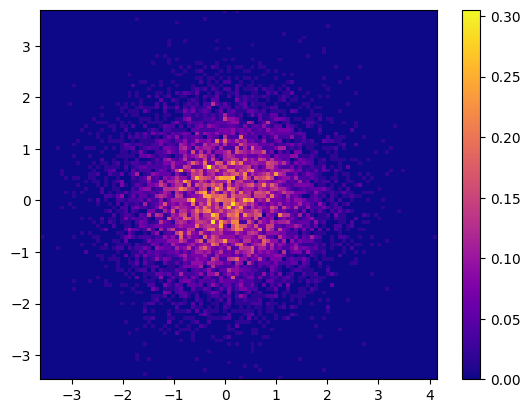

In [16]:
def marsaglia(n):
    X = []
    Y = []
    for i in range(n):
        V1 = np.random.uniform(-1,1)
        V2 = np.random.uniform(-1,1)
        r_kw = V1**2 + V2**2
        while r_kw>1:
            V1 = np.random.uniform(-1,1)
            V2 = np.random.uniform(-1,1)
            r_kw = V1**2 + V2**2
        X.append(np.sqrt((-2*np.log(r_kw))/r_kw)*V1)
        Y.append(np.sqrt((-2*np.log(r_kw))/r_kw)*V2)
    return X, Y

start = time.perf_counter()
x,y = marsaglia(10000)
end = time.perf_counter()
print(f'Metoda Marsaglii, czas wykonania: {end-start}')
plt.hist2d(x, y, bins = 100, cmap='plasma', density=True)
plt.colorbar()
plt.show()

### Algorytm symulacji trajektorii jednorodnego łańcucha Markowa w czasie dyskretnym

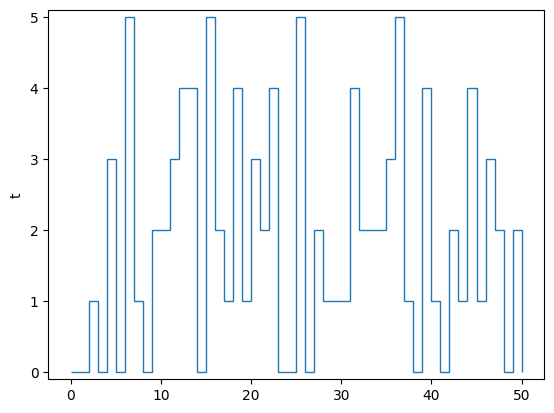

In [17]:
def markow_d(states=6):
    results = np.empty(50)
    x0 = 0
    prob_matrix = []
    for i in range(states):
        arr = np.random.random(states)
        prob_matrix.append(arr/arr.sum())
    prob_matrix=np.asarray(prob_matrix)
    for i in range(50):
        results[i] = x0
        ps = prob_matrix[x0]
        x0 = np.random.choice([i for i in range(states)], p = ps)
    return results

results = markow_d()
x_axis = np.linspace(0, 50, 51)
plt.ylim(-0.1, 5.1)
plt.ylabel('t')
plt.stairs(results, x_axis)
plt.show()

### Algorytm symulacji trajektorii jednorodnego łańcucha Markowa w czasie ciągłym

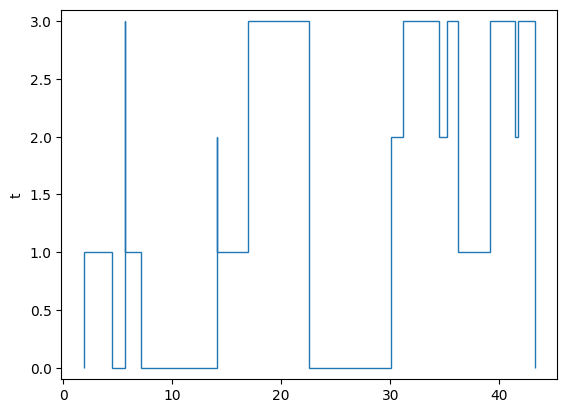

In [18]:
def markow_c(states=4):
    times = np.empty(30)
    t = 0
    x0 = 0
    prob_matrix = []
    results = np.empty(30)
    for i in range(states):
        arr = np.random.random(states)
        prob_matrix.append(arr/arr.sum())
    prob_matrix=np.asarray(prob_matrix)
    lambdas = np.array(np.random.randint(0, 4, size = states))
    for i in range(30):
        t += np.random.exponential(lambdas[x0])
        times[i] = t
        results[i] = x0
        ps = prob_matrix[x0]
        x0 = np.random.choice([i for i in range(states)], p = ps)
    return results, times

results, times = markow_c()
times = np.append(times, times[-1])
plt.ylim(-0.1, 3.1)
plt.ylabel('t')
plt.stairs(results, times)
plt.show()

### Proces ryzyka dla złożonego procesu Poissona

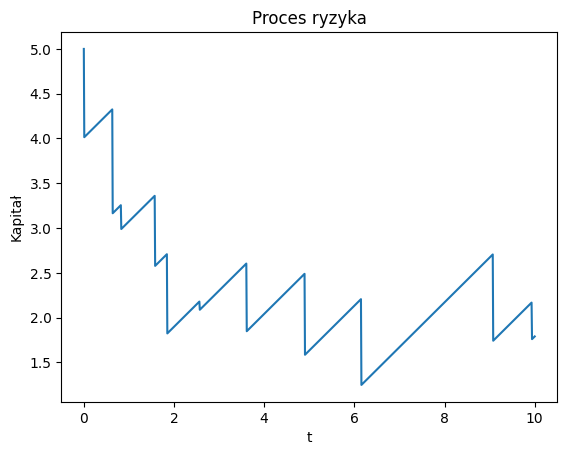

In [23]:
def process(T=10):
    results = np.array([0])
    lam = 1
    t = 0
    while t <= T:
        u = np.random.uniform(0,1)
        t = t - np.log(u)/lam
        results = np.append(results, t)
    return results
    
def risk_process(T, intervals, u=5, c=0.5, lam=1):
    times = np.linspace(0, T, 1000)
    damages = np.random.uniform(np.random.exponential(scale = lam, size = len(intervals)))
    idxs = []
    for time in intervals:
        for t in times:
            if time<t:
                idxs.append(list(times).index(t))
                break
    income = c*times
    damage_idx = list(zip(damages, idxs))
    for damage, idx in damage_idx:
        income[idx:] -= damage
    values = u + income
    return times, values

intervals = process()
ts, ys = risk_process(10, intervals)

plt.plot(ts, ys)
plt.xlabel('t')
plt.ylabel('Kapitał')
plt.title('Proces ryzyka')
plt.show()